<a href="https://colab.research.google.com/github/Elvenisboy/fuling_colaboratory/blob/master/%E7%8C%AB%E7%8B%97%E5%A4%A7%E6%88%98AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!cp /content/drive/colab-drive/cats-vs-dogs/dogs-vs-cats.zip ./
!unzip ./dogs-vs-cats.zip
# !unzip ./test1.zip
!unzip ./train.zip

In [0]:
import os, shutil, glob

import cv2
import numpy as np

import keras
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


In [0]:
def load_data():
  images = os.listdir(train)
  num = len(images)
  train_data = []
  train_label = []
  test_data = []
  test_label = []
  
  for i in range(5000):
    if i % 2:
      img = image.load_img('./train/' + 'dog.' + str(i) + '.jpg', target_size=(224, 224))
      x = image.img_to_array(img)
      train_data.append(x)
      train_label.append(1)
    else:
      img = image.load_img('./train/' + 'cat.' + str(i) + '.jpg', target_size=(224, 224))
      x = image.img_to_array(img)
      train_data.append(x)
      train_label.append(0)
  for i in range(5000, 10000):
    if i % 2:
      img = image.load_img('./train/' + 'dog.' + str(i) + '.jpg', target_size=(224, 224))
      x = image.img_to_array(img)
      test_data.append(x)                                        
      test_label.append(1)
    else:
      img = image.load_img('./train/' + 'cat.' + str(i) + '.jpg', target_size=(224, 224))
      x = image.img_to_array(img)
      test_data.append(x)
      test_data.append(0)
  return train_data, train_label, test_data, test_label        

In [0]:
train_data, train_label, test_data, test_label = load_data()
train_data, test_data = np.array(train_data), np.array(test_data)
# train_data, test_data = train_data/255, test_data/255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


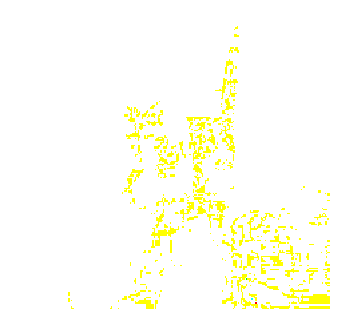

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


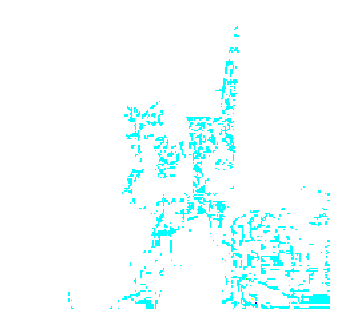

In [0]:
import matplotlib.pyplot as plt

img = train_data[0]
# print(img)
plt.imshow(img)
plt.axis("off")
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()


In [0]:
# keras.utils.to_categorical(y, num_classes=None, dtype='float32')
# num_classes: 总类别数。
train_label = keras.utils.to_categorical(train_label, 2)
test_label = keras.utils.to_categorical(test_label, 2)


In [0]:
# AlexNet
model = Sequential()
#第一段
model.add(Convolution2D(filters=96, kernel_size=(11,11),
                 strides=(4,4), padding='valid',
                 input_shape=(resize,resize,3),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), 
                       padding='valid'))
#第二段
model.add(Convolution2D(filters=256, kernel_size=(5,5), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), 
                       padding='valid'))
#第三段
model.add(Convolution2D(filters=384, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(Convolution2D(filters=384, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(Convolution2D(filters=256, kernel_size=(3,3), 
                 strides=(1,1), padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), 
                       strides=(2,2), padding='valid'))
#第四段
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
!mkdir output


In [0]:
model.fit(train_data, train_label,
          batch_size = 64,
          epochs = 50,
          validation_split = 0.2,
          shuffle = True)

# model.save('./outputs/cat_vs_dogs.h5')
# model.save('/content/drive/colab-drive/cats-vs-dogs/cat_vs_dogs_alex.h5')

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
2112/4000 [==============>...............] - ETA: 5:00 - loss: 0.9173 - acc: 0.5133

In [0]:
model.save('/content/drive/colab-drive/cats-vs-dogs/cat_vs_dogs_alex_最终版.h5')
model.save('cat_vs_dogs.h5')

In [0]:
scores = model.evaluate(train_data, train_label, verbose=1)
print(scores)

In [0]:
scores = model.evaluate(test_data, test_label, verbose=1)
print(scores)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


for i in range(100):
  if i % 2:
      img_path = './train/' + 'dog.' + str(i) + '.jpg'
  else:
      img_path = './train/' + 'cat.' + str(i) + '.jpg'
      
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x)
  print(prediction)
  print(np.argmax(prediction))
  print(100*np.max(prediction))



In [0]:
# 猫是0， 狗是1